In [1]:
!pip install scanpy
!pip install igraph
!pip install leidenalg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.4/122.4 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 4.7 MB/s eta 0:00:00
  Created wheel for session-info: filename=session_info-1.0.0-py3-none-any.whl size=8026 sha256=ff8de30aa10a77c25196b8200f1ef7941ee7cd02ba9101a661e04b8c6dec448f
  Stored in directory: /root/.cache/pip/wheels/6a/aa/b9/eb5d4031476ec10802795b97ccf937b9bd998d68a9b268765a
Successfully built session-info
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 34.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 27.4 MB/s eta 0:00:00


In [2]:
import pandas as pd
import scanpy as sc

In [3]:
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor="white")

scanpy==1.10.1 anndata==0.10.7 umap==0.5.6 numpy==1.25.2 scipy==1.11.4 pandas==2.0.3 scikit-learn==1.2.2 statsmodels==0.14.2 igraph==0.11.5 pynndescent==0.5.12


In [4]:
# Montar el drive en el sistema de ficheros
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
results_file = "/content/drive/MyDrive/TFM/kang_result.h5ad"  # the file that will store the analysis results

In [59]:
adata = sc.read("kang_counts_25k.h5ad", backup_url="https://figshare.com/ndownloader/files/34464122")

In [60]:
adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`

In [61]:
adata

AnnData object with n_obs × n_vars = 24673 × 15706
    obs: 'nCount_RNA', 'nFeature_RNA', 'tsne1', 'tsne2', 'label', 'cluster', 'cell_type', 'replicate', 'nCount_SCT', 'nFeature_SCT', 'integrated_snn_res.0.4', 'seurat_clusters'
    var: 'name'
    obsm: 'X_pca', 'X_umap'

# Preprocessing

normalizing counts per cell
    finished (0:00:00)


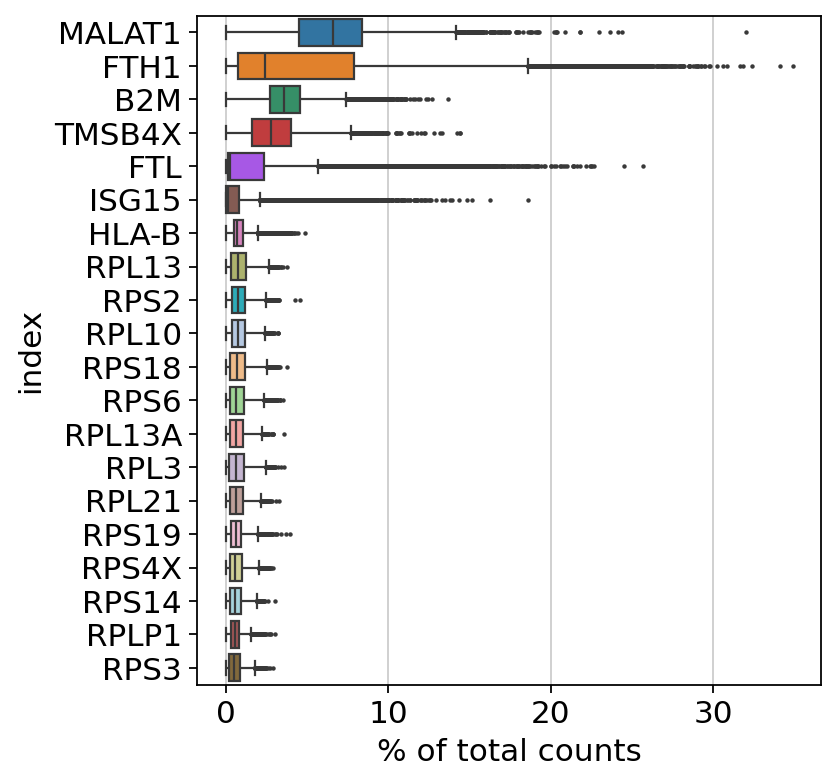

In [62]:
sc.pl.highest_expr_genes(adata, n_top=20) #Fraction of counts assigned to each gene over all cells.

In [63]:
sc.pp.calculate_qc_metrics(
    adata, percent_top=None, log1p=False, inplace=True
)

In [64]:
adata

AnnData object with n_obs × n_vars = 24673 × 15706
    obs: 'nCount_RNA', 'nFeature_RNA', 'tsne1', 'tsne2', 'label', 'cluster', 'cell_type', 'replicate', 'nCount_SCT', 'nFeature_SCT', 'integrated_snn_res.0.4', 'seurat_clusters', 'n_genes_by_counts', 'total_counts'
    var: 'name', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    obsm: 'X_pca', 'X_umap'

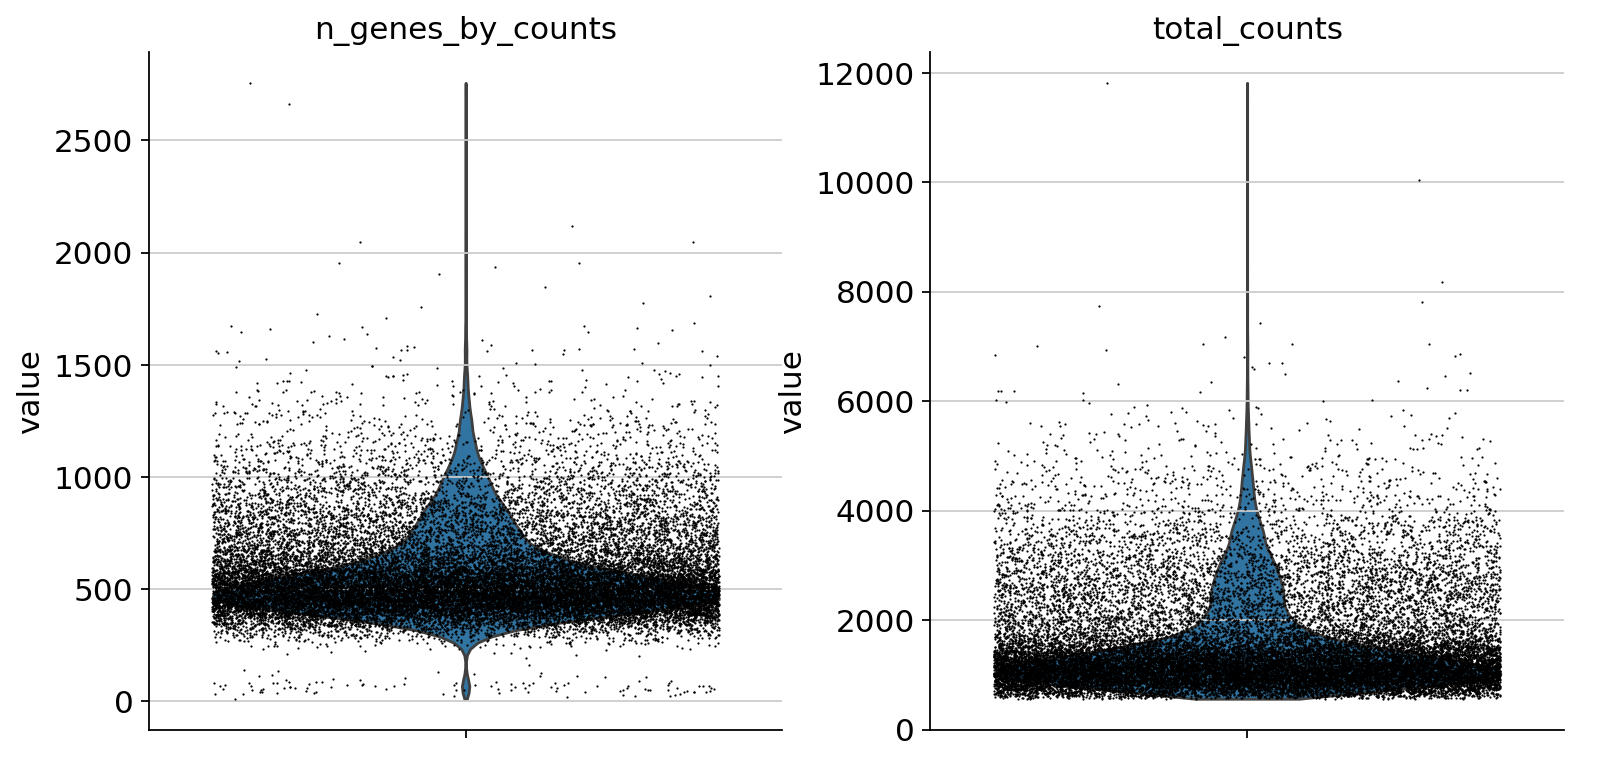

In [65]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts"],
    jitter=0.4,
    multi_panel=True,
)

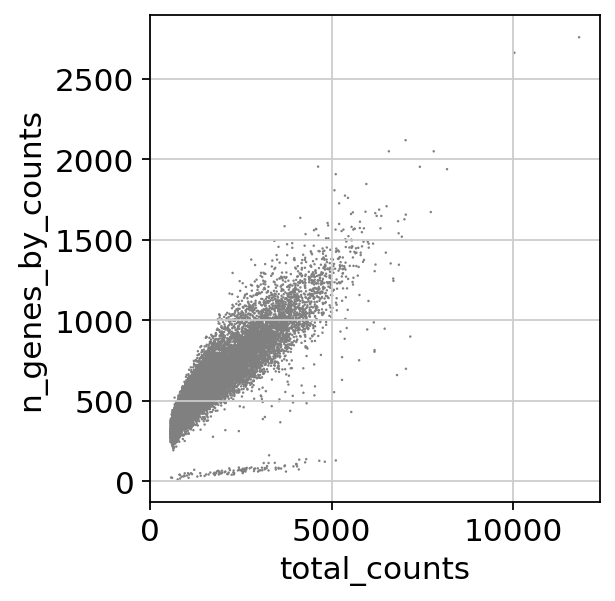

In [66]:
sc.pl.scatter(adata, x="total_counts", y="n_genes_by_counts")

In [67]:
adata.obs["n_genes_by_counts"].describe()

count    24673.000000
mean       574.900985
std        206.621105
min         12.000000
25%        441.000000
50%        519.000000
75%        652.000000
max       2757.000000
Name: n_genes_by_counts, dtype: float64

In [68]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 111 cells that have less than 200 genes expressed
filtered out 5 genes that are detected in less than 3 cells


In [69]:
adata = adata[adata.obs.n_genes_by_counts < 2500, :]

In [70]:
adata.obs["n_genes_by_counts"].describe()

count    24560.000000
mean       577.015147
std        203.348981
min        204.000000
25%        442.000000
50%        520.000000
75%        653.000000
max       2118.000000
Name: n_genes_by_counts, dtype: float64

In [71]:
sc.pp.normalize_total(adata, target_sum=1e4)

/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_normalization.py:206: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell
    finished (0:00:00)


In [72]:
sc.pp.log1p(adata)

In [73]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


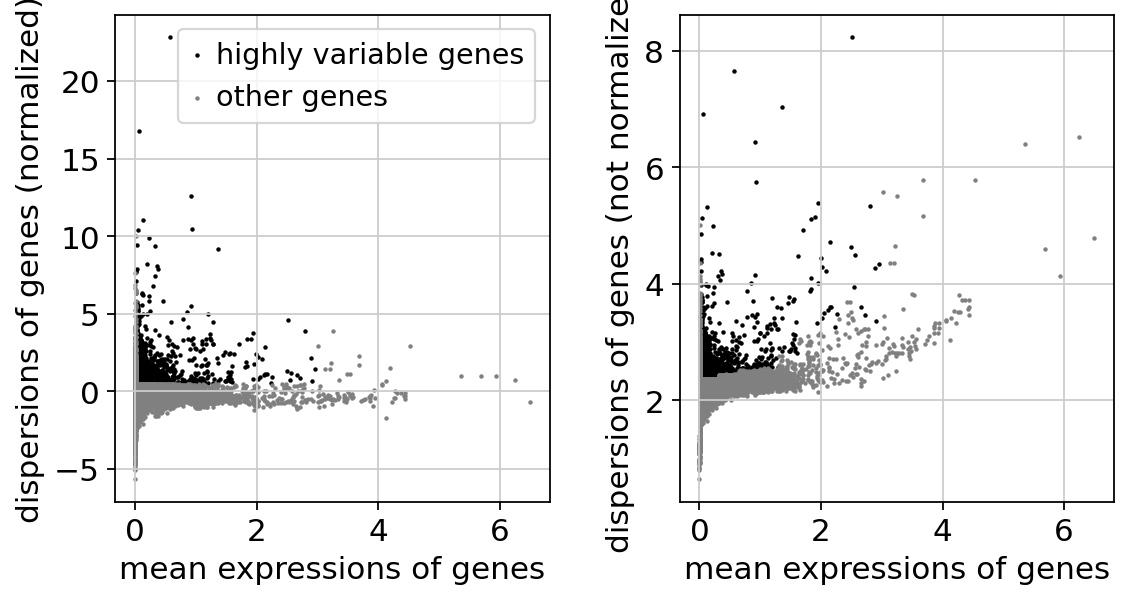

In [74]:
sc.pl.highly_variable_genes(adata)

In [75]:
adata.raw = adata

In [76]:
adata = adata[:, adata.var.highly_variable]

In [77]:
sc.pp.regress_out(adata, ["total_counts"])

regressing out ['total_counts']
    sparse input is densified and may lead to high memory use


/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_simple.py:641: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


    finished (0:00:46)


In [78]:
sc.pp.scale(adata, max_value=10)

In [79]:
adata.write(results_file)